# Home Credit Default Risk

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# ----------------------------------------------------
import sklearn
import scipy
#import statsmodels.api as sm 
from scipy.stats import shapiro

# ----------------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn import under_sampling, over_sampling

# ----------------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate

# ----------------------------------------------------
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

# ----------------------------------------------------
from sklearn.metrics import auc, roc_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import Counter

# ----------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

## Import Dataset

In [2]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv("application_test.csv")
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
previous_application = pd.read_csv('previous_application.csv')
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
installments_payments = pd.read_csv('installments_payments.csv')

## Define functions

In [3]:
def outlier_detect(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    return df[((df[col] < (q1_col - 1.5 * iqr_col)) |(df[col] > (q3_col + 1.5 * iqr_col)))]

# ----------------------------------------------------------
def lower_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    lower = df[(df[col] < (q1_col - 1.5 * iqr_col))]
    return lower

# ----------------------------------------------------------
def upper_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    upper = df[(df[col] > (q3_col + 1.5 * iqr_col))]
    return upper

# ----------------------------------------------------------
def preprocess(df, col):
    print("*********************** {} ***********************\n".format(col))
    print("lower outlier: {} ****** upper outlier: {}\n".format(lower_outlier(df,col).shape[0], upper_outlier(df,col).shape[0]))
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    df[col].plot(kind='box', subplots=True, sharex=False, vert=False)
    plt.subplot(2,1,2)
    df[col].plot(kind='density', subplots=True, sharex=False)
    plt.show()

# ----------------------------------------------------------
def preprocess_cat(df, col):
    print("******************** {} ********************\n".format(col))
    df[col].value_counts().plot(kind='bar')
    plt.xticks(rotation='vertical')
    plt.show()
    
# ----------------------------------------------------------
def replace_upper(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 9999999
    upper = q3_col + 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x < (upper)), tmp)
    df[col] = df[col].replace(tmp, upper)

# ----------------------------------------------------------
def replace_lower(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 1111111
    lower = q1_col - 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x > (lower)), tmp)
    df[col] = df[col].replace(tmp, lower)

# ----------------------------------------------------------
def replace_mode(df, col):
    df[col] = df[col].fillna(df[col].mode()[0])
    print("NaN in {} raplaced with {}".format(col, df[col].mode()[0]))

# ----------------------------------------------------------
def replace_mean(df, col):
    df[col] = df[col].fillna(df[col].mean())
    print("NaN in {} raplaced with {}".format(col, df[col].mean()))
    

def replace_median(df, col):
    df[col] = df[col].fillna(df[col].median())
    print("NaN in {} raplaced with {}".format(col, df[col].median()))
    

# ----------------------------------------------------------
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

def cross_validation(x, y, model):
    result= cross_val_score(model, x, y, cv=kfold, scoring="roc_auc", n_jobs=-1)
    print("Score: %f" % result.mean())
    
# ----------------------------------------------------------
def RndSrch_Tune(model, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='roc_auc', cv = kfold, n_jobs=-1, random_state=100)
    clf.fit(X, y)
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    return (clf.best_score_)

## Data Understanding

In [4]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [6]:
train.shape

(307511, 122)

0    282686
1     24825
Name: TARGET, dtype: int64

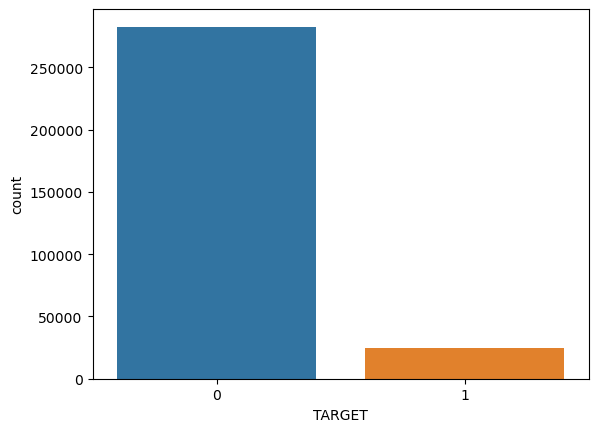

In [7]:
sns.countplot(x = "TARGET", data = train)
train.loc[:, 'TARGET'].value_counts()

In [8]:
print(train.info())
print("*******************************")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
*******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


In [9]:
pd.set_option('display.max_rows', train.shape[0])
train.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,1.000020e+05,189145.500000,278202.000000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.000000e+00,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-2.522900e+04,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-1.791200e+04,-2760.000000,-1213.000000,-289.000000,3.652430e+05


In [10]:
pd.DataFrame(train.isnull().sum().sort_values(ascending = False))

,0
COMMONAREA_MEDI,214865
COMMONAREA_AVG,214865
COMMONAREA_MODE,214865
NONLIVINGAPARTMENTS_MODE,213514
NONLIVINGAPARTMENTS_AVG,213514
NONLIVINGAPARTMENTS_MEDI,213514
FONDKAPREMONT_MODE,210295
LIVINGAPARTMENTS_MODE,210199
LIVINGAPARTMENTS_AVG,210199
LIVINGAPARTMENTS_MEDI,210199


In [11]:
pd.DataFrame(test.isnull().sum().sort_values(ascending = False))

,0
COMMONAREA_AVG,33495
COMMONAREA_MODE,33495
COMMONAREA_MEDI,33495
NONLIVINGAPARTMENTS_AVG,33347
NONLIVINGAPARTMENTS_MODE,33347
NONLIVINGAPARTMENTS_MEDI,33347
FONDKAPREMONT_MODE,32797
LIVINGAPARTMENTS_AVG,32780
LIVINGAPARTMENTS_MODE,32780
LIVINGAPARTMENTS_MEDI,32780


In [12]:
data_bureau_agg=bureau.groupby(by='SK_ID_CURR').mean()

## Preprocessing

### Numerical Field (Manage Missing Data)

In [13]:
threshold_train = len(train) * 0.60
int(threshold_train)

184506

In [14]:
threshold_test = len(test) * 0.60
int(threshold_test)

29246

In [15]:
train[["LIVINGAREA_MEDI"]].head()


,LIVINGAREA_MEDI
0,0.0193
1,0.0558
2,NaN
3,NaN
4,NaN


In [16]:
print("In train data:\n")
print(train.columns[train.isnull().sum() > int(threshold_train)])
print("******************************************")
print("In test data:\n")
print(test.columns[test.isnull().sum() > int(threshold_test)])

In train data:

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'FONDKAPREMONT_MODE'],
      dtype='object')
******************************************
In test data:

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'FONDKAPREMONT_MODE'],
      dtype='object')


In [17]:
train_new = train.dropna(axis=1, thresh=threshold_train)
print(train_new.shape)
print("******************************************")
test_new = test.dropna(axis=1, thresh=threshold_test)
print(test_new.shape)

(307511, 73)
******************************************
(48744, 72)


In [18]:
numeric_feature = train_new.dtypes!=object
final_numeric_feature = train_new.columns[numeric_feature].tolist()

#----------------------------------------------------
numeric_feature_test = test_new.dtypes!=object
final_numeric_feature_test = test_new.columns[numeric_feature_test].tolist()

In [19]:
numeric = train_new[final_numeric_feature]

#-------------------------------------------
numeric_test = test_new[final_numeric_feature_test]

numeric.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
discrete_features = numeric.dtypes!= float
final_discrete_feature = numeric.columns[discrete_features].tolist()
discrete = numeric[final_discrete_feature]

#-------------------------------------------
discrete_features_test = numeric_test.dtypes!= float
final_discrete_feature_test = numeric_test.columns[discrete_features_test].tolist()
discrete_test = numeric_test[final_discrete_feature_test]

discrete.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,0,-9461,-637,-2120,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,-16765,-1188,-291,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,0,-19046,-225,-2531,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,-19005,-3039,-2437,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,-19932,-3038,-3458,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
pd.DataFrame(discrete.isnull().sum().sort_values(ascending = False))

,0
SK_ID_CURR,0
FLAG_DOCUMENT_2,0
FLAG_DOCUMENT_4,0
FLAG_DOCUMENT_5,0
FLAG_DOCUMENT_6,0
FLAG_DOCUMENT_7,0
FLAG_DOCUMENT_8,0
FLAG_DOCUMENT_9,0
FLAG_DOCUMENT_10,0
FLAG_DOCUMENT_11,0


In [22]:
pd.DataFrame(discrete_test.isnull().sum().sort_values(ascending = False))

,0
SK_ID_CURR,0
CNT_CHILDREN,0
FLAG_DOCUMENT_4,0
FLAG_DOCUMENT_5,0
FLAG_DOCUMENT_6,0
FLAG_DOCUMENT_7,0
FLAG_DOCUMENT_8,0
FLAG_DOCUMENT_9,0
FLAG_DOCUMENT_10,0
FLAG_DOCUMENT_11,0


In [23]:
continuous_features = numeric.dtypes==float
final_continuous_feature = numeric.columns[continuous_features].tolist()
continuous = numeric[final_continuous_feature]

#-------------------------------------------
continuous_features_test = numeric_test.dtypes==float
final_continuous_feature_test = numeric_test.columns[continuous_features_test].tolist()
continuous_test = numeric_test[final_continuous_feature_test]

continuous.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,CNT_FAM_MEMBERS,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,202500.0,406597.5,24700.5,351000.0,0.018801,-3648.0,1.0,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1186.0,2.0,0.622246,NaN,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67500.0,135000.0,6750.0,135000.0,0.010032,-4260.0,1.0,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,135000.0,312682.5,29686.5,297000.0,0.008019,-9833.0,2.0,0.650442,NaN,2.0,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,121500.0,513000.0,21865.5,513000.0,0.028663,-4311.0,1.0,0.322738,NaN,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
pd.DataFrame(continuous.isnull().sum().sort_values(ascending = False))

,0
EXT_SOURCE_3,60965
AMT_REQ_CREDIT_BUREAU_YEAR,41519
AMT_REQ_CREDIT_BUREAU_QRT,41519
AMT_REQ_CREDIT_BUREAU_MON,41519
AMT_REQ_CREDIT_BUREAU_WEEK,41519
AMT_REQ_CREDIT_BUREAU_DAY,41519
AMT_REQ_CREDIT_BUREAU_HOUR,41519
OBS_60_CNT_SOCIAL_CIRCLE,1021
DEF_60_CNT_SOCIAL_CIRCLE,1021
DEF_30_CNT_SOCIAL_CIRCLE,1021


In [25]:
pd.DataFrame(continuous_test.isnull().sum().sort_values(ascending = False))

,0
EXT_SOURCE_3,8668
AMT_REQ_CREDIT_BUREAU_YEAR,6049
AMT_REQ_CREDIT_BUREAU_QRT,6049
AMT_REQ_CREDIT_BUREAU_MON,6049
AMT_REQ_CREDIT_BUREAU_WEEK,6049
AMT_REQ_CREDIT_BUREAU_DAY,6049
AMT_REQ_CREDIT_BUREAU_HOUR,6049
OBS_60_CNT_SOCIAL_CIRCLE,29
DEF_60_CNT_SOCIAL_CIRCLE,29
DEF_30_CNT_SOCIAL_CIRCLE,29


In [26]:
continuous_col = continuous.columns

In [27]:
Q1 = train_new.quantile(0.25)
Q3 = train_new.quantile(0.75)
IQR = Q3 - Q1

In [28]:
#for i in range(len(continuous_col)):
    #preprocess(continuous[continuous_col], continuous_col[i])

In [29]:
continuous_is_null = continuous.isnull().sum() != 0
final_continuous_feature = continuous.columns[continuous_is_null].tolist()
print("In train: \n",final_continuous_feature)

print("****************************************")
continuous_is_null_test = continuous_test.isnull().sum() != 0
final_continuous_feature_test = continuous_test.columns[continuous_is_null_test].tolist()
print("In test: \n",final_continuous_feature_test)

In train: 
 ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
****************************************
In test: 
 ['AMT_ANNUITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


In [30]:
print("In train:\n")
for i in range(len(final_continuous_feature)):
    replace_mean(continuous, final_continuous_feature[i])

print("************************************")
print("In test:\n")
for i in range(len(final_continuous_feature_test)):
    replace_mean(continuous_test, final_continuous_feature_test[i])

In train:

NaN in AMT_ANNUITY raplaced with 27108.573909183444
NaN in AMT_GOODS_PRICE raplaced with 538396.2074288887
NaN in CNT_FAM_MEMBERS raplaced with 2.1526654504421012
NaN in EXT_SOURCE_2 raplaced with 0.5143926741308488
NaN in EXT_SOURCE_3 raplaced with 0.5108529061805426
NaN in OBS_30_CNT_SOCIAL_CIRCLE raplaced with 1.4222454239942892
NaN in DEF_30_CNT_SOCIAL_CIRCLE raplaced with 0.1434206662533827
NaN in OBS_60_CNT_SOCIAL_CIRCLE raplaced with 1.4052921791902133
NaN in DEF_60_CNT_SOCIAL_CIRCLE raplaced with 0.10004894123788487
NaN in DAYS_LAST_PHONE_CHANGE raplaced with -962.8587883320869
NaN in AMT_REQ_CREDIT_BUREAU_HOUR raplaced with 0.0064024481939340665
NaN in AMT_REQ_CREDIT_BUREAU_DAY raplaced with 0.007000210532644792
NaN in AMT_REQ_CREDIT_BUREAU_WEEK raplaced with 0.03436193569730462
NaN in AMT_REQ_CREDIT_BUREAU_MON raplaced with 0.26739526000773584
NaN in AMT_REQ_CREDIT_BUREAU_QRT raplaced with 0.2654741495984415
NaN in AMT_REQ_CREDIT_BUREAU_YEAR raplaced with 1.8999744

In [31]:
pd.DataFrame(continuous.isnull().sum().sort_values(ascending = False))

,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_WEEK,0
AMT_REQ_CREDIT_BUREAU_DAY,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
DAYS_LAST_PHONE_CHANGE,0
DEF_60_CNT_SOCIAL_CIRCLE,0
OBS_60_CNT_SOCIAL_CIRCLE,0


In [32]:
pd.DataFrame(continuous_test.isnull().sum().sort_values(ascending = False))

,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_WEEK,0
AMT_REQ_CREDIT_BUREAU_DAY,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
DAYS_LAST_PHONE_CHANGE,0
DEF_60_CNT_SOCIAL_CIRCLE,0
OBS_60_CNT_SOCIAL_CIRCLE,0


In [33]:
numeric[continuous_col] = continuous[continuous_col]

# ----------------------------------------------
numeric_test[continuous_col] = continuous_test[continuous_col]

In [34]:
numeric.shape

(307511, 61)

In [35]:
numeric.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMEN

### Categorical field (Manage Missing Data)

In [36]:
categorical_feature = train_new.dtypes==object
final_categorical_feature = train_new.columns[categorical_feature].tolist()

#----------------------------------------------------
categorical_feature_test = test_new.dtypes==object
final_categorical_feature_test = test_new.columns[categorical_feature_test].tolist()

In [37]:
categorical = train_new[final_categorical_feature]

#---------------------------------------------
categorical_test = test_new[final_categorical_feature_test]
categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion


In [38]:
pd.DataFrame(categorical.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,96391
NAME_TYPE_SUITE,1292
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [39]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,15605
NAME_TYPE_SUITE,911
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [40]:
col_names_cat = categorical.columns

******************** NAME_CONTRACT_TYPE ********************



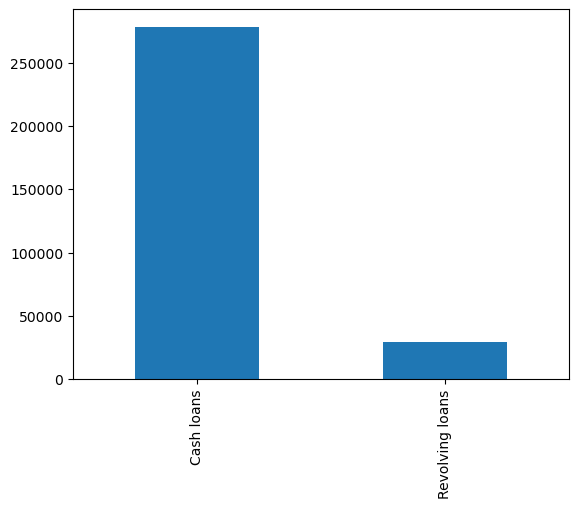

******************** CODE_GENDER ********************



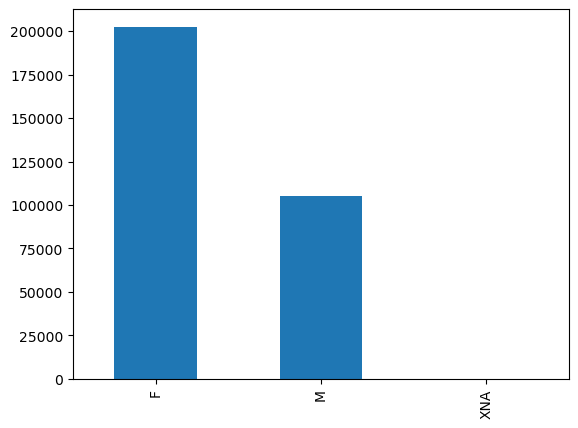

******************** FLAG_OWN_CAR ********************



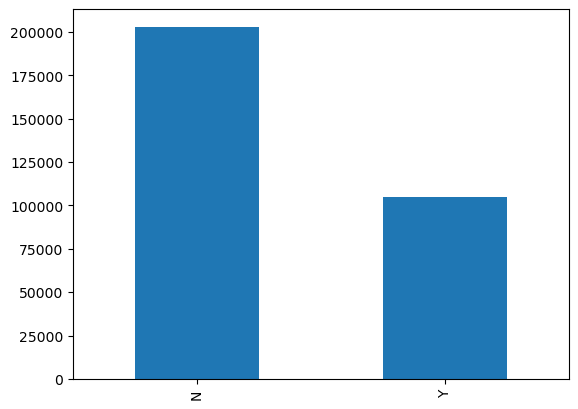

******************** FLAG_OWN_REALTY ********************



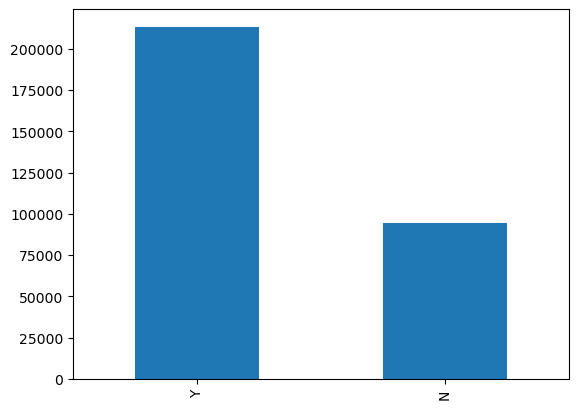

******************** NAME_TYPE_SUITE ********************



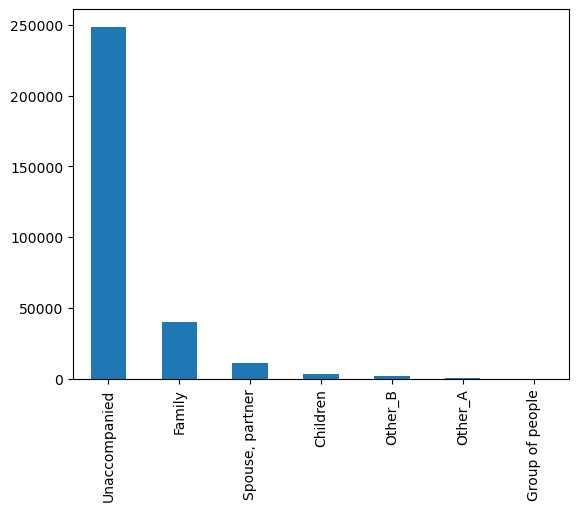

******************** NAME_INCOME_TYPE ********************



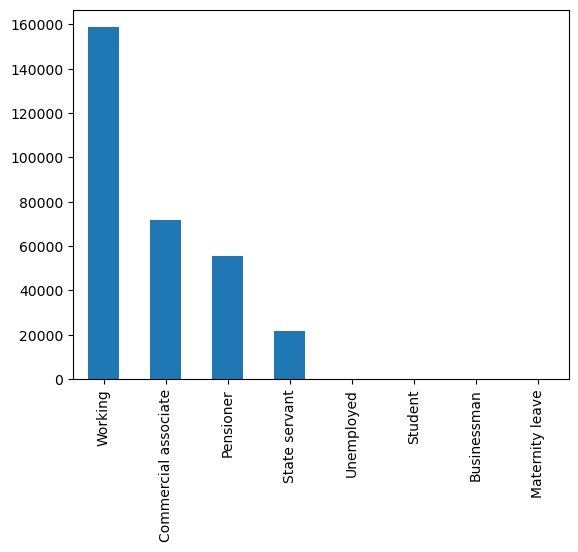

******************** NAME_EDUCATION_TYPE ********************



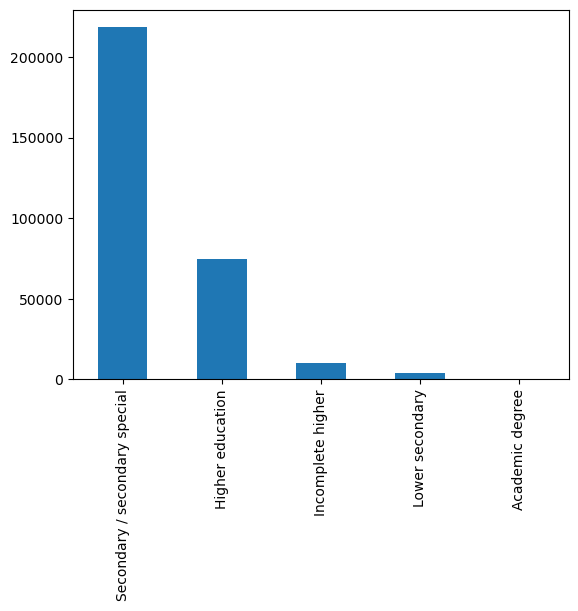

******************** NAME_FAMILY_STATUS ********************



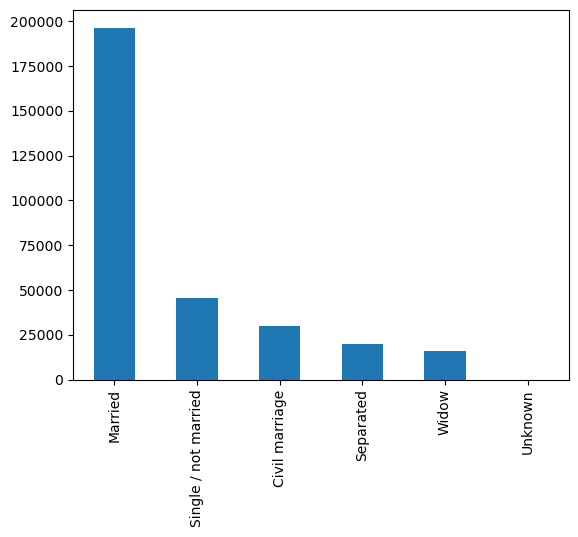

******************** NAME_HOUSING_TYPE ********************



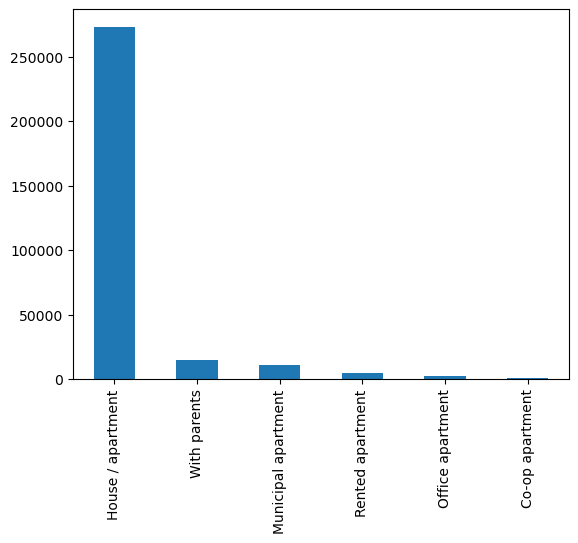

******************** OCCUPATION_TYPE ********************



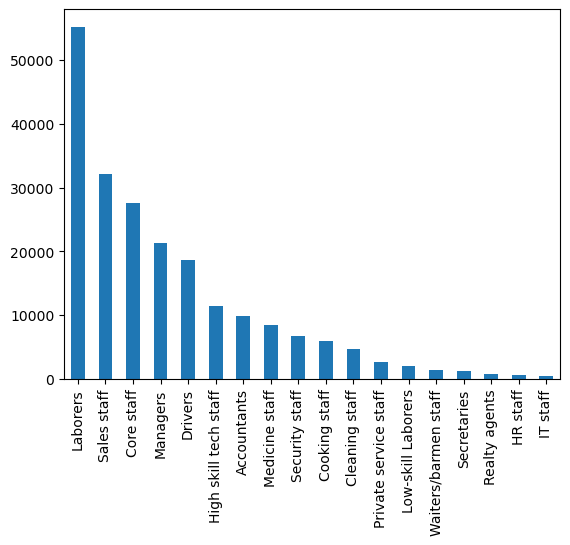

******************** WEEKDAY_APPR_PROCESS_START ********************



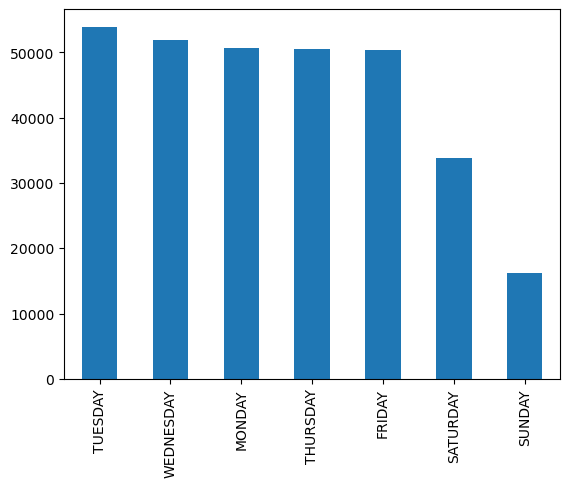

******************** ORGANIZATION_TYPE ********************



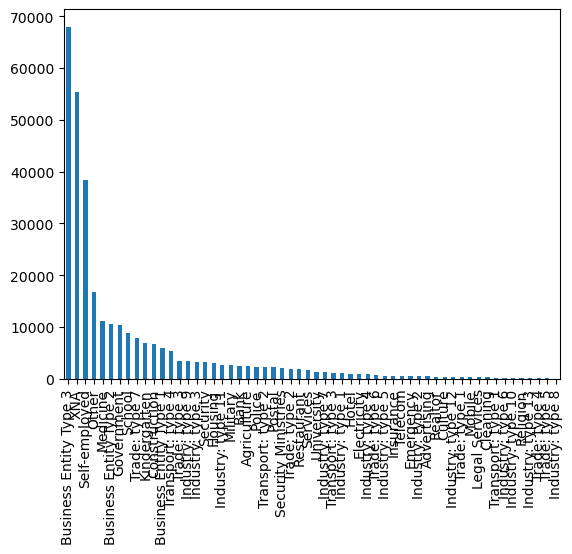

In [41]:
for i in range(len(col_names_cat)):
    preprocess_cat(categorical, col_names_cat[i])

In [42]:
print("unique number is = {}\nunique values are: \n{} ".format(len(train_new['ORGANIZATION_TYPE'].unique()), train_new['ORGANIZATION_TYPE'].unique()))

unique number is = 58
unique values are: 
['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other' 'XNA'
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Housing' 'Kindergarten'
 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministries' 'Transport: type 4' 'Industry: type 1' 'Emergency'
 'Security' 'Trade: type 2' 'University' 'Transport: type 3' 'Police'
 'Business Entity Type 1' 'Postal' 'Industry: type 4' 'Agriculture'
 'Restaurant' 'Culture' 'Hotel' 'Industry: type 7' 'Trade: type 3'
 'Industry: type 3' 'Bank' 'Industry: type 9' 'Insurance' 'Trade: type 6'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 12' 'Mobile'
 'Trade: type 1' 'Industry: type 5' 'Industry: type 10' 'Legal Services'
 'Advertising' 'Trade: type 5' 'Cleaning' 'Industry: type 13'
 'Trade: type 4' 'Telecom' 'Industry: type 8' 'Realtor' 'Industry: type 6'] 


In [43]:
print("In train:\n")
for i in range(len(col_names_cat)):
    replace_mode(categorical, col_names_cat[i])

print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names_cat)):
    replace_mode(categorical_test, col_names_cat[i])

In train:

NaN in NAME_CONTRACT_TYPE raplaced with Cash loans
NaN in CODE_GENDER raplaced with F
NaN in FLAG_OWN_CAR raplaced with N
NaN in FLAG_OWN_REALTY raplaced with Y
NaN in NAME_TYPE_SUITE raplaced with Unaccompanied
NaN in NAME_INCOME_TYPE raplaced with Working
NaN in NAME_EDUCATION_TYPE raplaced with Secondary / secondary special
NaN in NAME_FAMILY_STATUS raplaced with Married
NaN in NAME_HOUSING_TYPE raplaced with House / apartment
NaN in OCCUPATION_TYPE raplaced with Laborers
NaN in WEEKDAY_APPR_PROCESS_START raplaced with TUESDAY
NaN in ORGANIZATION_TYPE raplaced with Business Entity Type 3


****************************************

In test:

NaN in NAME_CONTRACT_TYPE raplaced with Cash loans
NaN in CODE_GENDER raplaced with F
NaN in FLAG_OWN_CAR raplaced with N
NaN in FLAG_OWN_REALTY raplaced with Y
NaN in NAME_TYPE_SUITE raplaced with Unaccompanied
NaN in NAME_INCOME_TYPE raplaced with Working
NaN in NAME_EDUCATION_TYPE raplaced with Secondary / secondary special
NaN in N

In [44]:
pd.DataFrame(categorical.isnull().sum().sort_values(ascending = False))

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_TYPE_SUITE,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0


In [45]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_TYPE_SUITE,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0


### Label Encoder

In [46]:
categorical.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
# ---------------------------------------------
categorical_test.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

In [47]:
le = LabelEncoder() 
categorical = categorical.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical_test = categorical_test.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START
0,0,1,0,1,6,7,4,3,1,8,6
1,0,0,0,0,1,4,1,1,1,3,1
2,1,1,1,1,6,7,4,3,1,8,1
3,0,0,0,1,6,7,4,0,1,8,6
4,0,1,0,1,6,7,4,3,1,3,4


In [48]:
print("In train: ",categorical.shape)
print("In test: ",categorical_test.shape)

In train:  (307511, 11)
In test:  (48744, 11)


In [49]:
col_names_cat = categorical.columns
col_names = numeric_test.columns

In [50]:
train_new[col_names_cat] = categorical[col_names_cat]
train_new[col_names] = numeric[col_names]

# ----------------------------------------------------
test_new[col_names] = numeric_test[col_names]
test_new[col_names_cat] = categorical_test[col_names_cat]

In [51]:
train_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
test_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

In [52]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 72 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  int32  
 3   CODE_GENDER                  307511 non-null  int32  
 4   FLAG_OWN_CAR                 307511 non-null  int32  
 5   FLAG_OWN_REALTY              307511 non-null  int32  
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307511 non-null  float64
 10  AMT_GOODS_PRICE              307511 non-null  float64
 11  NAME_TYPE_SUITE              307511 non-null  int32  
 12  NAME_INCOME_TYPE             307511 non-null  int32  
 13 

### Manage Duplicate Data

In [53]:
print("In train: ",train_new.loc[train.duplicated()].shape)
#--------------------------------------------------
print("In test: ",test_new.loc[test.duplicated()].shape)

In train:  (0, 72)
In test:  (0, 71)


### Split Train Test

In [54]:
train_new.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
5,100008,0,0,1,0,1,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,1.000000,1.000000
6,100009,0,0,0,1,1,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.000000,0.000,0.000000,1.000000,1.000000,2.000000
7,100010,0,0,1,1,1,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
8,100011,0,0,0,0,1,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
9,100012,0,1,1,0,1,0,135000.0,405000.0,20250.0,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974


In [55]:
train_new.shape

(307511, 72)

In [56]:
X = train_new.drop(["SK_ID_CURR", "TARGET"], axis = 1) 
Y = train_new.TARGET
X_validasi = test_new.drop(["SK_ID_CURR"], axis = 1)

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 200)
print("X Training shape", X_train.shape)
print("X Testing shape", X_test.shape)
print("Y Training shape", y_train.shape)
print("Y Testing shape", y_test.shape)

X Training shape (215257, 70)
X Testing shape (92254, 70)
Y Training shape (215257,)
Y Testing shape (92254,)


### Numerical Field Manage Outlier

In [58]:
col_names = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

final_numeric_feature_new = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

numeric = X_train[col_names]

numeric.head(10)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
226316,0,135000.0,225000.0,15034.5,225000.0,0.009549,-9209,-705,-1104.0,-470,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
41700,0,180000.0,1129500.0,58612.5,1129500.0,0.026392,-16698,-3732,-8307.0,-240,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,1.000000,3.000000
80304,4,157500.0,508495.5,27715.5,454500.0,0.007330,-11411,-1096,-809.0,-3937,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,3.000000
67995,1,135000.0,90000.0,4374.0,90000.0,0.022625,-10442,-404,-3840.0,-1472,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
284728,0,157500.0,326664.0,16677.0,234000.0,0.030755,-12141,-409,-5389.0,-2075,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
303615,0,38250.0,284400.0,10345.5,225000.0,0.024610,-22784,365243,-7691.0,-4868,...,0,0,0,0,0.000000,0.000,0.000000,1.000000,0.000000,2.000000
22063,0,90000.0,229500.0,11038.5,229500.0,0.015221,-20470,365243,-6920.0,-3820,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,2.000000
83244,0,405000.0,1442596.5,38182.5,1129500.0,0.003818,-17220,-663,-350.0,-782,...,1,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
100285,2,247500.0,640080.0,24259.5,450000.0,0.003813,-11462,-1828,-3858.0,-3790,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,6.000000
154836,0,256500.0,135000.0,6696.0,135000.0,0.031329,-12155,-114,-4985.0,-2770,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974


In [59]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(outlier_detect(X_train,col_names[i]).shape[0])))
    
'''print("\n\n***************************************\n")
print("In test:\n")
for i in range(len(col_names_test)):
    print("{}: {}".format(col_names_test[i],(outlier_detect(numeric_test,col_names_test[i]).shape[0])))'''

In train:

CNT_CHILDREN: 2899
AMT_INCOME_TOTAL: 9809
AMT_CREDIT: 4607
AMT_ANNUITY: 5320
AMT_GOODS_PRICE: 10352
REGION_POPULATION_RELATIVE: 5923
DAYS_BIRTH: 0
DAYS_EMPLOYED: 50684
DAYS_REGISTRATION: 459
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 1
FLAG_EMP_PHONE: 38877
FLAG_WORK_PHONE: 42909
FLAG_CONT_MOBILE: 416
FLAG_PHONE: 0
FLAG_EMAIL: 12296
CNT_FAM_MEMBERS: 2722
REGION_RATING_CLIENT: 56324
REGION_RATING_CLIENT_W_CITY: 54615
HOUR_APPR_PROCESS_START: 1582
REG_REGION_NOT_LIVE_REGION: 3240
REG_REGION_NOT_WORK_REGION: 10892
LIVE_REGION_NOT_WORK_REGION: 8736
REG_CITY_NOT_LIVE_CITY: 16692
REG_CITY_NOT_WORK_CITY: 49413
LIVE_CITY_NOT_WORK_CITY: 38504
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 14026
DEF_30_CNT_SOCIAL_CIRCLE: 25258
OBS_60_CNT_SOCIAL_CIRCLE: 13746
DEF_60_CNT_SOCIAL_CIRCLE: 18668
DAYS_LAST_PHONE_CHANGE: 291
FLAG_DOCUMENT_2: 8
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 13
FLAG_DOCUMENT_5: 3227
FLAG_DOCUMENT_6: 19044
FLAG_DOCUMENT_7: 40
FLAG_DOCUMENT_8: 17481
FLAG_DOCUMENT_9: 849
FLAG

'print("\n\n***************************************\n")\nprint("In test:\n")\nfor i in range(len(col_names_test)):\n    print("{}: {}".format(col_names_test[i],(outlier_detect(numeric_test,col_names_test[i]).shape[0])))'

In [60]:
outlier = []
for i in range(len(final_numeric_feature_new)):
    if outlier_detect(X_train[final_numeric_feature_new],final_numeric_feature_new[i]).shape[0] !=0:
        outlier.append(final_numeric_feature_new[i])

'''outlier_test = []
for i in range(len(final_numeric_feature_test)):
    if outlier_detect(numeric_test[final_numeric_feature_test],final_numeric_feature_test[i]).shape[0] !=0:
        outlier_test.append(final_numeric_feature_test[i])'''

'outlier_test = []\nfor i in range(len(final_numeric_feature_test)):\n    if outlier_detect(numeric_test[final_numeric_feature_test],final_numeric_feature_test[i]).shape[0] !=0:\n        outlier_test.append(final_numeric_feature_test[i])'

In [61]:
# without TARGET field
#col_names = outlier_test

In [62]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(X_train,col_names[i]).shape[0])))
    
'''print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))'''

In train:

CNT_CHILDREN: 2899
AMT_INCOME_TOTAL: 9809
AMT_CREDIT: 4607
AMT_ANNUITY: 5320
AMT_GOODS_PRICE: 10352
REGION_POPULATION_RELATIVE: 5923
DAYS_BIRTH: 0
DAYS_EMPLOYED: 38869
DAYS_REGISTRATION: 0
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 42909
FLAG_CONT_MOBILE: 0
FLAG_PHONE: 0
FLAG_EMAIL: 12296
CNT_FAM_MEMBERS: 2722
REGION_RATING_CLIENT: 33753
REGION_RATING_CLIENT_W_CITY: 30638
HOUR_APPR_PROCESS_START: 412
REG_REGION_NOT_LIVE_REGION: 3240
REG_REGION_NOT_WORK_REGION: 10892
LIVE_REGION_NOT_WORK_REGION: 8736
REG_CITY_NOT_LIVE_CITY: 16692
REG_CITY_NOT_WORK_CITY: 49413
LIVE_CITY_NOT_WORK_CITY: 38504
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 14026
DEF_30_CNT_SOCIAL_CIRCLE: 25258
OBS_60_CNT_SOCIAL_CIRCLE: 13746
DEF_60_CNT_SOCIAL_CIRCLE: 18668
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_2: 8
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 13
FLAG_DOCUMENT_5: 3227
FLAG_DOCUMENT_6: 19044
FLAG_DOCUMENT_7: 40
FLAG_DOCUMENT_8: 17481
FLAG_DOCUMENT_9: 849
FLAG_DOCUMENT_1

'print("\n\n****************************************\n")\nprint("In test:\n")\nfor i in range(len(col_names)):\n    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))'

In [63]:
for i in range(len(col_names)):
    replace_upper(X_train, col_names[i])   
    
#------------------------------------------------------
'''for i in range(len(col_names)):
    replace_upper(numeric_test, col_names[i])'''

'for i in range(len(col_names)):\n    replace_upper(numeric_test, col_names[i])'

In [64]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(X_train,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
'''print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))'''

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_PHONE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_2: 0
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_10: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_12: 0
FLAG_DOCUMENT_13: 0
FLAG_DOCUMENT_14: 0
FLAG_DOCUMEN

'print("In test:\n")\nfor i in range(len(col_names)):\n    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))'

In [65]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(X_train,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
'''print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))'''

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 11815
DAYS_REGISTRATION: 459
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 1
FLAG_EMP_PHONE: 38877
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 416
FLAG_PHONE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 22571
REGION_RATING_CLIENT_W_CITY: 23977
HOUR_APPR_PROCESS_START: 1170
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 291
FLAG_DOCUMENT_2: 0
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_10: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_12: 0
FLAG_DOCUMENT_13: 0
FLAG_DO

'print("In test:\n")\nfor i in range(len(col_names)):\n    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))'

In [66]:
for i in range(len(col_names)):
    replace_lower(X_train, col_names[i])
    
# #--------------------------------------------------
'''for i in range(len(col_names)):
    replace_lower(numeric_test, col_names[i])'''

'for i in range(len(col_names)):\n    replace_lower(numeric_test, col_names[i])'

In [67]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(X_train,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
'''print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))'''

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_PHONE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_2: 0
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_10: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_12: 0
FLAG_DOCUMENT_13: 0
FLAG_DOCUMENT_14: 0
FLAG_DOCUMEN

'print("In test:\n")\nfor i in range(len(col_names)):\n    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))'

In [68]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215257 entries, 226316 to 1818
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_CONTRACT_TYPE           215257 non-null  int32  
 1   CODE_GENDER                  215257 non-null  int32  
 2   FLAG_OWN_CAR                 215257 non-null  int32  
 3   FLAG_OWN_REALTY              215257 non-null  int32  
 4   CNT_CHILDREN                 215257 non-null  float64
 5   AMT_INCOME_TOTAL             215257 non-null  float64
 6   AMT_CREDIT                   215257 non-null  float64
 7   AMT_ANNUITY                  215257 non-null  float64
 8   AMT_GOODS_PRICE              215257 non-null  float64
 9   NAME_TYPE_SUITE              215257 non-null  int32  
 10  NAME_INCOME_TYPE             215257 non-null  int32  
 11  NAME_EDUCATION_TYPE          215257 non-null  int32  
 12  NAME_FAMILY_STATUS           215257 non-null  int32  
 

### Normalization

In [69]:
scaler = MinMaxScaler(feature_range=(0, 1))
col = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

X_train[col] = scaler.fit_transform(X_train[col])
X_test[col] = scaler.fit_transform(X_test[col])

#X_train[col] = pd.DataFrame(scaler.fit_transform(X_train[col]))
#X_test[col] = pd.DataFrame(scaler.transform(X_test[col]))

In [70]:
X_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
226316,0.0,0.0,0.0,1.0,0.0,0.350649,0.114531,0.223321,0.141869,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25333
41700,0.0,0.0,1.0,1.0,0.0,0.494949,0.690050,0.948551,0.837370,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40000
80304,0.0,0.5,0.0,1.0,1.0,0.422799,0.294915,0.434359,0.318339,0.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40000
67995,0.0,0.0,0.0,1.0,0.4,0.350649,0.028633,0.045907,0.038062,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
284728,0.0,0.5,0.0,1.0,0.0,0.422799,0.179218,0.250655,0.148789,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25333


### Handling class-imbalance

In [71]:
# Oversampling
ROS = RandomOverSampler(sampling_strategy='minority', random_state=1)
X_train_ROS, y_train_ROS = ROS.fit_resample(X_train, y_train)
np.bincount(y_train_ROS)

array([197903, 197903], dtype=int64)

## Modeling

### Logistic Regression

In [72]:
logreg = LogisticRegression() # inisiasi object dengan nama logreg
logreg.fit(X_train_ROS, y_train_ROS) # fit model regression dari data train
scores_logreg_test = cross_validation(X_test, y_test, logreg)
print(scores_logreg_test)

Score: 0.737147
None


### Logistic Regression Classifier HyperParameters

In [73]:
logreg_oversampling = LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg_oversampling.fit(X_train_ROS, y_train_ROS)
scores_logreg_oversampling_test = cross_validation(X_test, y_test, logreg_oversampling)
print(scores_logreg_oversampling_test)

Score: 0.505456
None


### Light GBM

In [74]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_ROS, y_train_ROS)
scores_logreg_test = cross_validation(X_test, y_test, lgbm)
print(scores_logreg_test)

Score: 0.743697
None


### LightGBM Classifier HyperParameters

In [75]:
lgb_tune = LGBMClassifier(**{'reg_lambda': 0.1, 
                        'reg_alpha': 0.2, 
                        'num_leaves': 70, 
                        'n_estimators': 250, 
                        'min_child_samples': 800, 
                        'learning_rate': 0.05,
                        'max_bin': 500,
                        'objective': 'binary',
                        'n_jobs': -1,
                        'class_weight':'balanced',
                        'random_state':100})

lgb_tune.fit(X_train_ROS, y_train_ROS)
lgb_tune_test = cross_validation(X_test, y_test, lgb_tune)
print(lgb_tune_test)

Score: 0.744834
None


## Feature Value

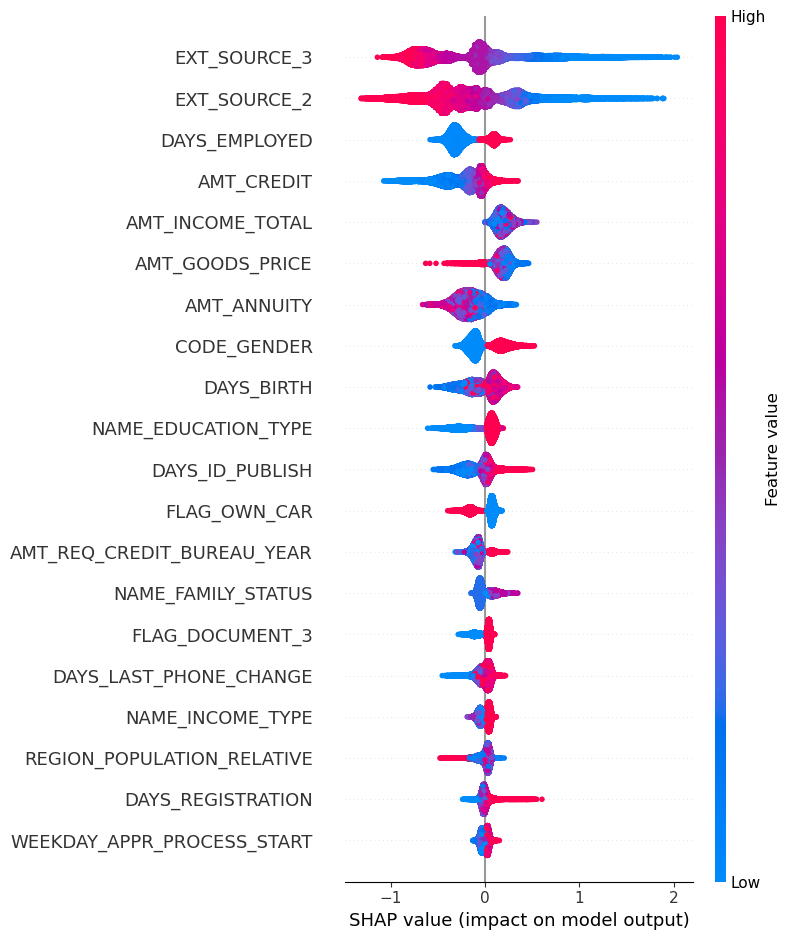

<Figure size 640x480 with 0 Axes>

In [76]:
import shap
explainer = shap.TreeExplainer(lgb_tune)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)
plt.savefig('grafik_xy.png', transparent=True)

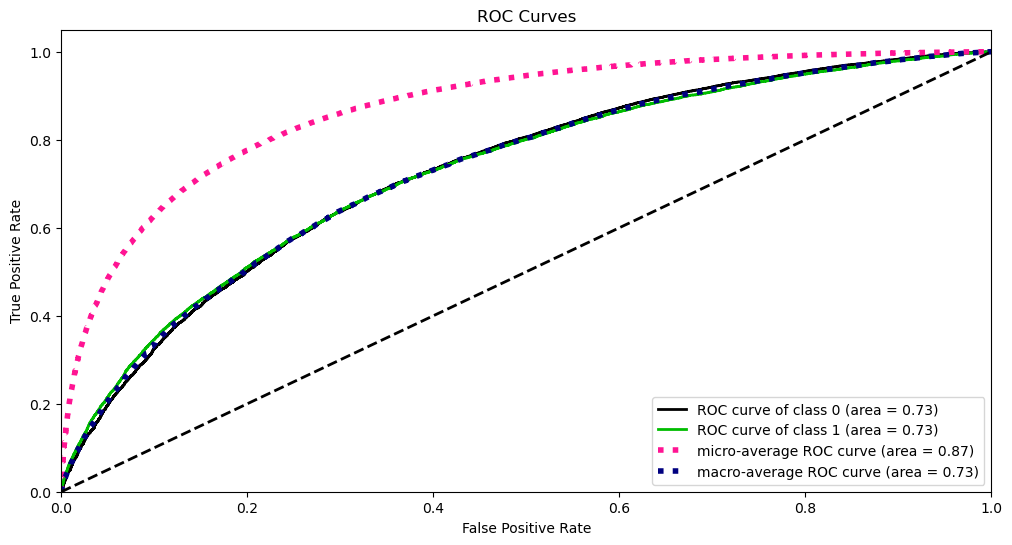

In [77]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc(y_test, lgb_tune.predict_proba(X_test), figsize=(12,6))
plt.show()

## Result

In [ ]:
LGB_tune_pred = lgb_tune.predict(X_validasi)
hasil = pd.DataFrame()
hasil['SK_ID_CURR'] = test_new['SK_ID_CURR']
hasil['TARGET'] = LGB_tune_pred
hasil.to_csv("lgb_baseline.csv", index=False)
hasil.head()
print(hasil['TARGET'].value_counts())

0    45378
1     3366
Name: TARGET, dtype: int64


In [84]:
print(hasil['TARGET'].value_counts())

0    45378
1     3366
Name: TARGET, dtype: int64
